## Pre-processing and Visualization

In [13]:
# Import the required libraries.
import re
import math
import random
import collections
import operator
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import confusion_matrix
from collections import defaultdict

random.seed(11)
np.random.seed(11)

In [2]:
def parse_sentence(sentence):
    '''
    Function for parsing the words and tags from the
    sentences of the input corpus.
    '''
    word_tag_pairs = sentence.split(" ")
    words = []
    tags = []

    for i, word_tag in enumerate(word_tag_pairs):
        word, tag = word_tag.strip().rsplit('/', 1)
        words.append(word)
        tags.append(tag)
        
    return words, tags

In [3]:
# Parse the sentences into a list.
parsed_sentences = []

with open('./Brown_train.txt', 'r') as file:
    sentences = file.readlines()

    for sentence in sentences:
        sentence = sentence.strip()
        parsed_sentences.append(parse_sentence(sentence))

In [4]:
def get_vocab(X_train, Y_train):
    '''
    Function for building the vocabulary from the training set of
    words and tags.
    '''
    vocabulary2id = dict()    
    tag2id = dict()
    vocabulary2id['UNK'] = 0

    for sent in X_train:
        for word in sent:
            if word not in vocabulary2id.keys():
                vocabulary2id[word] = len(vocabulary2id)

    for sent in Y_train:
        for tag in sent:
            if tag not in tag2id.keys():
                tag2id[tag] = len(tag2id)
    
    return vocabulary2id, tag2id

def get_word_tag_counts(X_train, Y_train, vocabulary2id, tag2id):
    '''
    Function for calculating the counts pertaining to the
    individual word tags.
    '''
    wordcount = defaultdict(int)
    tagcount = defaultdict(int)
    tagpaircount = defaultdict(int)
    tagtriplecount = defaultdict(int)
    
    for sent in X_train:
        for word in sent:
            wordcount[word] += 1
    
    for sent in Y_train:
        for tag in sent:
            tagcount[tag] += 1
    
    for sent in Y_train:
        for i in range(len(sent) - 1):
            tagpaircount[sent[i], sent[i + 1]] += 1

    for sent in Y_train:
        for i in range(len(sent) - 2):
            tagtriplecount[sent[i], sent[i + 1], sent[i + 2]] += 1
    
    return wordcount, tagcount, tagpaircount, tagtriplecount

In [5]:
# Token to map all out-of-vocabulary words (OOVs).
UNK = "UNK"
# Index for UNK
UNKid = 0
epsilon = 1e-100
array, ones, zeros, multiply, unravel_index = np.array, np.ones, np.zeros, np.multiply, np.unravel_index

class HMM:
    def __init__(self, state_list, observation_list, transition_proba = None,
                 observation_proba = None, initial_state_proba = None, 
                 smoothing_obs = 0.01, transition_proba1 = None, prob_abs = 0.00001):
        '''
        Builds a Hidden Markov Model.
        * state_list is the list of state symbols [q_0...q_(N-1)]
        * observation_list is the list of observation symbols [v_0...v_(M-1)]
        * transition_proba is the transition probability matrix
            [a_ij] a_ij,a_ik = Pr(Y_(t+1)=q_i|Y_t=q_j,Y_(t-1)=q_k)
        * observation_proba is the observation probablility matrix
            [b_ki] b_ki = Pr(X_t=v_k|Y_t=q_i)
        * initial_state_proba is the initial state distribution
            [pi_i] pi_i = Pr(Y_0=q_i)
        '''
        # Number of states.
        self.N = len(state_list)
        # Number of possible emissions.
        self.M = len(observation_list)
        self.prob_abs = prob_abs
        self.omega_Y = state_list
        self.omega_X = observation_list

        if transition_proba1 is None:
            self.transition_proba1 = zeros( (self.N, self.N), float) 
        else:
            self.transition_proba1 = transition_proba1

        if transition_proba is None:
            self.transition_proba = zeros( (self.N, self.N, self.N), float) 
        else:
            self.transition_proba=transition_proba

        if observation_proba is None:
            self.observation_proba = zeros( (self.M, self.N), float) 
        else:
            self.observation_proba = observation_proba

        if initial_state_proba is None:
            self.initial_state_proba = zeros( (self.N,), float ) 
        else:
            self.initial_state_proba = initial_state_proba

        # Build indexes, i.e., the mapping between token and int.
        self.make_indexes()
        self.smoothing_obs = smoothing_obs 
        
    def make_indexes(self):
        '''
        Function for creating the reverse table that maps
        states/observations names to their index in the probabilities
        array.
        '''
        self.Y_index = {}

        for i in range(self.N):
            self.Y_index[self.omega_Y[i]] = i
            
        self.X_index = {}
            
        for i in range(self.M):
            self.X_index[self.omega_X[i]] = i
        
    def get_observationIndices(self, observations):
        '''
        Function for returning observation indices,
        and dealing with OOVs.
        '''
        indices = zeros( len(observations), int )
        k = 0

        for o in observations:
            if o in self.X_index:
                indices[k] = self.X_index[o]
            else:
                indices[k] = UNKid

            k += 1

        return indices

    def data2indices(self, sent): 
        '''
        Function for extracting the words and tags and returning a
        list of indices for each.
        '''
        wordids = list()
        tagids  = list()

        for couple in sent:
            wrd = couple[0]
            tag = couple[1]

            if wrd in self.X_index:
                wordids.append(self.X_index[wrd])
            else:
                wordids.append(UNKid)

            tagids.append(self.Y_index[tag])

        return wordids, tagids
        
    def observation_estimation(self, pair_counts):
        '''
        Function for building the observation distribution where
        observation_proba is the observation probablility matrix.
        '''
        # Fill with counts.
        for pair in pair_counts:
            wrd = pair[0]
            tag = pair[1]
            cpt = pair_counts[pair]
            # For UNK.
            k = 0

            if wrd in self.X_index: 
                k = self.X_index[wrd]

            i = self.Y_index[tag]
            self.observation_proba[k, i] = cpt

        # Normalize.
        self.observation_proba = self.observation_proba + self.smoothing_obs
        self.observation_proba = self.observation_proba / self.observation_proba.sum(axis = 0).reshape(1, self.N)

    def transition_estimation(self, trans_counts):
        '''
        Function for building the transition distribution where 
        transition_proba is the transition matrix with:
        [a_ij] a[i, j] = Pr(Y_(t+1) = q_i | Y_t = q_j, Y_(t-1) = q_k)
        '''
        # Fill with counts.
        for triple in trans_counts:
            i = self.Y_index[triple[2]]
            j = self.Y_index[triple[1]]
            k = self.Y_index[triple[0]]
            self.transition_proba[k, j, i] = trans_counts[triple]

        # Normalize.
        self.transition_proba = self.transition_proba / self.transition_proba.sum(axis = 0).reshape(self.N, self.N)

    def transition_estimation1(self, trans_counts):
        '''
        Function for building the transition distribution where 
        transition_proba is the transition matrix with: 
        [a_ij] a[i,j] = Pr(Y_(t+1)=q_i|Y_t=q_j)
        '''
        # Fill with counts.
        for pair in trans_counts:
            i = self.Y_index[pair[1]]
            j = self.Y_index[pair[0]]
            self.transition_proba1[j, i] = trans_counts[pair]

        # Normalize.
        self.transition_proba1 = self.transition_proba1 / self.transition_proba1.sum(axis = 0).reshape(1, self.N)
        
    def init_estimation(self, init_counts):
        '''
        Function for building the initial distribution.
        '''
        # Fill with counts.
        for tag in init_counts:
            i = self.Y_index[tag]
            self.initial_state_proba[i] = init_counts[tag]

        # Normalize.
        self.initial_state_proba = self.initial_state_proba / sum(self.initial_state_proba)

    def supervised_training(self, pair_counts, trans_counts, init_counts, trans_counts1):
        '''
        Function for training the HMM's parameters.
        '''
        self.observation_estimation(pair_counts)
        self.transition_estimation(trans_counts)
        self.transition_estimation1(trans_counts1)
        self.init_estimation(init_counts)
        
    def viterbi(self, observations):
        if len(observations) < 2:
            return [hmm.Y_index[z] for z in observations]

        nSamples = len(observations)
        # Number of states.
        nStates = self.transition_proba.shape[0]
        # Scale factors (necessary to prevent underflow).
        c = np.zeros(nSamples)
        # Initialise viterbi table.
        viterbi = np.zeros((nStates, nStates, nSamples))
        # Initialise viterbi table.
        viterbi1 = np.zeros((nStates, nSamples))
        # Initialise the best path table.
        psi = np.zeros((nStates, nStates, nSamples))
        best_path = np.zeros(nSamples)
        idx0 = self.X_index[observations[0]]
        idx1 = self.X_index[observations[1]]
        viterbi1[:, 0] = self.initial_state_proba.T * self.observation_proba[idx0, :].T

        # Loop through the states.
        for s in range (0, nStates):
            for v in range (0, nStates):
                viterbi[s, v, 1] = viterbi1[s, 0] * self.transition_proba1[s, v] * self.observation_proba[idx1, v]

        psi[0] = 0;

        # Loop through time-stamps.
        for t in range(2, nSamples):
            idx = self.X_index[observations[t]]
            # Loop through the states.
            for s in range (0, nStates):
                for v in range (0, nStates):
                    self.transition_proba[np.isnan(self.transition_proba)] = self.prob_abs
                    trans_p = viterbi[:, s, t-1] * self.transition_proba[:, s, v]

                    if (math.isnan(trans_p[0])):
                        trans_p[0] = 0

                    psi[s, v, t], viterbi[s, v, t] = max(enumerate(trans_p), key = operator.itemgetter(1))
                    viterbi[s, v, t] = viterbi[s, v, t] * self.observation_proba[idx, v]

        cabbar = viterbi[:, :, nSamples - 1]
        best_path[nSamples - 1] = unravel_index(cabbar.argmax(), cabbar.shape)[1]
        best_path[nSamples - 2] = unravel_index(cabbar.argmax(), cabbar.shape)[0]

        # Return the best path, number of samples and psi.
        for t in range(nSamples - 3, -1, -1):
            best_path[t] = psi[int(round(best_path[t + 1])), int(round(best_path[t + 2])), t + 2]

        return best_path
        
    def fwd_bkw(self, observations):
        observations = x
        self = hmm
        nStates = self.transition_proba.shape[0]
        start_prob = self.initial_state_proba
        trans_prob = self.transition_proba1.transpose()
        emm_prob = self.observation_proba.transpose()

        # Forward part of the algorithm.
        fwd = []
        f_prev = {}

        for i, observation_i in enumerate(observations):
            f_curr = {}
            for st in range(nStates):
                if i == 0:
                    # Base case for the forward part.
                    prev_f_sum = start_prob[st]
                else:
                    prev_f_sum = sum(f_prev[k] * trans_prob[k][st] for k in range(nStates))

                f_curr[st] = emm_prob[st][self.X_index[observation_i]] * prev_f_sum

            fwd.append(f_curr)
            f_prev = f_curr

        p_fwd = sum(f_curr[k] for k in range(nStates))

        # Backward part of the algorithm.
        bkw = []
        b_prev = {}

        for i, observation_i_plus in enumerate(reversed(observations[1:] + [None,])):
            b_curr = {}
            for st in range(nStates):
                if i == 0:
                    # Base case for backward part.
                    b_curr[st] = 1.0
                else:
                    b_curr[st] = sum(trans_prob[st][l] * emm_prob[l][self.X_index[observation_i_plus]]
                                     * b_prev[l] for l in range(nStates))

            bkw.insert(0,b_curr)
            b_prev = b_curr

        p_bkw = sum(start_prob[l] * emm_prob[l][self.X_index[observations[0]]] * b_curr[l] for l in range(nStates))

        # Merging the two parts.
        posterior = []

        for i in range(len(observations)):
            posterior.append({st: fwd[i][st] * bkw[i][st] / p_fwd for st in range(nStates)})

        assert abs(p_fwd - p_bkw) < 1e-6
        return fwd, bkw, posterior

In [6]:
def make_counts(X, Y):
    ''' 
    Function for building the different count tables to train a HMM.
    Each count table is a dictionary. 
    '''
    c_words = dict()
    c_tags = dict()
    c_pairs= dict()
    c_transitions = dict()
    c_inits = dict()
    c_transitions1 = dict()
    
    for sent in zip(X, Y):
        sent = list(zip(*sent))
        for i in range(len(sent)):
            couple = sent[i]
            wrd = couple[0]
            tag = couple[1]

            # Word counts.
            if wrd in c_words:
                c_words[wrd] = c_words[wrd] + 1
            else:
                c_words[wrd] = 1

            # Tag counts.
            if tag in c_tags:
                c_tags[tag] = c_tags[tag] + 1
            else:
                c_tags[tag] = 1

            # Observation counts.
            if couple in c_pairs:
                c_pairs[couple] = c_pairs[couple] + 1
            else:
                c_pairs[couple] = 1

            if i >= 1:
                trans1 = (sent[i - 1][1], tag)
                if trans1 in c_transitions1:
                    c_transitions1[trans1] = c_transitions1[trans1] + 1
                else:
                    c_transitions1[trans1] = 1

            if i > 1:
                trans = (sent[i - 2][1], sent[i - 1][1], tag)
                if trans in c_transitions:
                    c_transitions[trans] = c_transitions[trans] + 1
                else:
                    c_transitions[trans] = 1
            else:
                if tag in c_inits:
                    c_inits[tag] = c_inits[tag] + 1
                else:
                    c_inits[tag] = 1
    
    return c_words,c_tags,c_pairs, c_transitions, c_inits, c_transitions1

In [7]:
# Build the test and training sets of sentences.
kf = KFold(n_splits = 3, shuffle = False)
parsed_sentences = np.asarray(parsed_sentences)
scores = []
scores1 = []
y_pred_idx = []
y_pred_idx1 = []
y_test_idx = []
y_test_idx1 = []

preds = []

for train_index, test_index in kf.split(parsed_sentences):
    train_data = parsed_sentences[train_index]
    test_data = parsed_sentences[test_index]
    X_train = [a[0] for a in train_data]
    Y_train = [a[1] for a in train_data]
    X_test = [a[0] for a in test_data]
    Y_test = [a[1] for a in test_data]
    
    # Build the vocabulary and word counts.
    vocabulary2id, tag2id = get_vocab(X_train, Y_train)
    wordcount, tagcount, tagpaircount, tagtriplecount = get_word_tag_counts(X_train, Y_train, vocabulary2id, tag2id)
    cwords, ctags, cpairs, ctrans, cinits, ctrans1 = make_counts(X_train, Y_train)
    
    state_list = list(ctags.keys())
    observation_list = [a[0] for a in sorted(vocabulary2id.items(), key = lambda x: x[1])]
    hmm = HMM(state_list = state_list, observation_list = observation_list,
              transition_proba = None, observation_proba = None, initial_state_proba = None,
              smoothing_obs = 0.4, prob_abs = 0)
    hmm.supervised_training(cpairs, ctrans, cinits, ctrans1)

    for x, y_true in zip(X_test, Y_test):
        for i in range(len(x)):
            if x[i] not in vocabulary2id.keys():
                x[i] = 'UNK'

        pred_idx = hmm.viterbi(x)
        y_pred = np.asarray([state_list[int(round(i))] for i in pred_idx])
        y_true = np.asarray(y_true)
        y_pred_idx += np.asarray([tag2id[lab] for lab in y_pred], dtype = np.int32).tolist()
        y_test_idx += np.asarray([tag2id[lab] for lab in y_true], dtype = np.int32).tolist()
        scores += (y_pred == y_true).tolist()

    x, y_true = X_train[0], Y_train[0]

    for x, y_true in zip(X_test, Y_test):
        for i in range(len(x)):
            if x[i] not in vocabulary2id.keys():
                x[i] = 'UNK'

        pred_probs = hmm.fwd_bkw(x)
        pred_idx = [max(probs.items(), key=lambda x: x[1])[0] for probs in pred_probs[2]]
        y_pred = np.asarray([state_list[int(round(i))] for i in pred_idx])
        y_true = np.asarray(y_true)
        y_pred_idx1 += np.asarray([tag2id[lab] for lab in y_pred], dtype = np.int32).tolist()
        y_test_idx1 += np.asarray([tag2id[lab] for lab in y_true], dtype = np.int32).tolist()
        scores1 += (y_pred == y_true).tolist()

prec, rec, fscore, _ = precision_recall_fscore_support(y_test_idx, y_pred_idx, average = 'macro')
prec1, rec1, fscore1, _ = precision_recall_fscore_support(y_test_idx1, y_pred_idx1, average = 'macro')

print('Overall Accuracy and Scores:')
print('Only Forward-Backward Accuracy: {}, Precision: {}, Recall: {}, FScore: {}'.format(np.asarray(scores1).mean(), prec1, rec1, fscore1))
print('Viterbi Accuracy: {}, Precision: {}, Recall: {}, FScore: {}'.format(np.asarray(scores).mean(), prec, rec, fscore))

/home/stud/btech/cse/2016/mukuntha.cs16/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide
/home/stud/btech/cse/2016/mukuntha.cs16/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:288: RuntimeWarning: invalid value encountered in double_scalars


Overall Accuracy and Scores:
Only Forward-Backward Accuracy: 0.7866681150107981, Precision: 0.7522332251027066, Recall: 0.7410914676078869, FScore: 0.7181261096051349
Viterbi Accuracy: 0.8836249353308209, Precision: 0.7957061479967794, Recall: 0.837373245121495, FScore: 0.8017269798075152


In [24]:
y_pred_idx = np.asarray(y_pred_idx)
y_test_idx = np.asarray(y_test_idx)

def get_scores(Y_test_idx, y_pred_test, average='weighted'):
    acc = (y_pred_test == Y_test_idx).mean()
    prec, rec, fscore, _ = precision_recall_fscore_support(Y_test_idx, y_pred_test, average=average)
    return acc, prec, rec, fscore

cm = confusion_matrix(y_pred_idx, y_test_idx)
accuracy = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal()
_, precision, recall, f1_scores = get_scores(y_pred_idx, y_test_idx, None)

In [28]:
for tag, tagid in tag2id.items():
    print('TAG: {} - Accuracy: {}, F1: {}, Precision: {}, Recall: {}'.format(tag, accuracy[tagid], f1_scores[tagid], precision[tagid], recall[tagid]))

TAG: ADP - Accuracy: 0.8553072369326786, F1: 0.9051307578369716, Precision: 0.9611179867986799, Recall: 0.8553072369326786
TAG: DET - Accuracy: 0.9193410451456092, F1: 0.9218097709579148, Precision: 0.9242917911123179, Recall: 0.9193410451456092
TAG: NOUN - Accuracy: 0.9388786992514747, F1: 0.9235870678304968, Precision: 0.9087855669113766, Recall: 0.9388786992514747
TAG: VERB - Accuracy: 0.9348468682769839, F1: 0.9248178845188865, Precision: 0.915001797545067, Recall: 0.9348468682769839
TAG: ADJ - Accuracy: 0.8826033170486235, F1: 0.8449641190344758, Precision: 0.8104039120557545, Recall: 0.8826033170486235
TAG: CONJ - Accuracy: 0.9195300191076397, F1: 0.8244381494811664, Precision: 0.747170582226762, Recall: 0.9195300191076397
TAG: PRT - Accuracy: 0.8974353535139263, F1: 0.9073964846054028, Precision: 0.9175812258708194, Recall: 0.8974353535139263
TAG: . - Accuracy: 0.9117073350263148, F1: 0.9505330408590047, Precision: 0.9928126753413311, Recall: 0.9117073350263148
TAG: ADV - Accura

In [34]:
# Confusion Matrix
cm

array([[37276,   346,   490,   401,   543,  1582,  1436,   229,   847,
           34,   381,    17],
       [  151, 40850,   336,   340,   429,   641,   408,    11,   731,
           66,   458,    13],
       [   63,    75, 75760,  1601,  1138,   645,   299,     5,   582,
          210,   107,   207],
       [   61,   153,  1372, 53448,   584,   506,   544,     0,   392,
           15,    81,    17],
       [   38,   112,  1965,   893, 42094,  1459,    88,    14,   870,
           24,   100,    36],
       [   45,   450,   250,   303,  1501, 54861,   114,    31,  1166,
            9,   888,    44],
       [  581,   481,   266,   662,  1185,   823, 42306,    67,   600,
           88,    73,     9],
       [   22,   266,    92,    76,  1316,  2415,   258, 74316,  2116,
           30,   590,    16],
       [  443,   662,   240,   140,  1846,  2721,   227,     0, 28973,
           10,   174,    20],
       [    7,   158,   846,   208,   352,  2164,   238,   180,   239,
         6298,   197

In [35]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

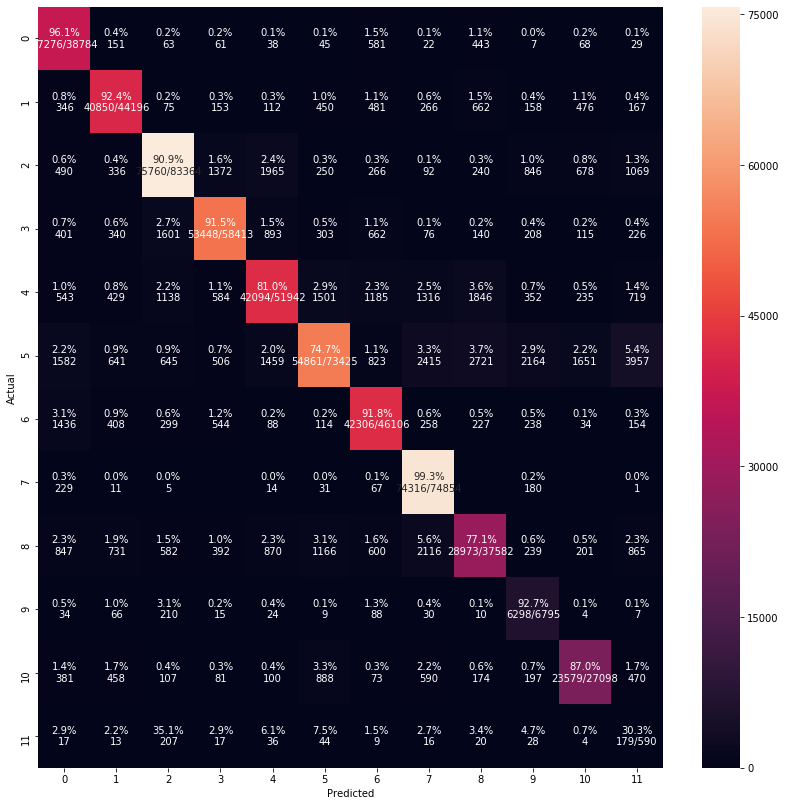

In [44]:
cm_analysis(y_test_idx, y_pred_idx, None, ymap=None, figsize=(14, 14))